In [5]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

from ar_adasyn import ar_adasyn

# Configuración inicial
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter

In [6]:
# Cargar dataset ecoli
ruta_ecoli = "../datasets/ecoli/ecoli.data"
df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)

# Separar características y etiquetas
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values

# Etiquetas binarias
y_bin = np.where(y == 'cp', 1, 0)

# Clases minoritaria y mayoritaria
X_min = X[y_bin == 1]
X_maj = X[y_bin == 0]


C:\Users\User\AppData\Local\Temp\ipykernel_7048\1697306660.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)


In [11]:
from ar_adasyn import ar_adasyn

X_sinteticas = ar_adasyn(X_min, X_maj, k=5, random_state=42)

print("Cantidad de muestras sintéticas generadas:", X_sinteticas.shape[0])


Cantidad de muestras sintéticas generadas: 44


In [12]:
X_resampled = np.vstack([X, X_sinteticas])
y_resampled = np.hstack([y_bin, np.ones(len(X_sinteticas))])


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

modelo = RandomForestClassifier(random_state=42)
scores = cross_val_score(modelo, X_resampled, y_resampled, cv=5, scoring='f1')

print("F1 score promedio tras AR-ADASYN:", np.mean(scores))


F1 score promedio tras AR-ADASYN: 0.9505244116613978


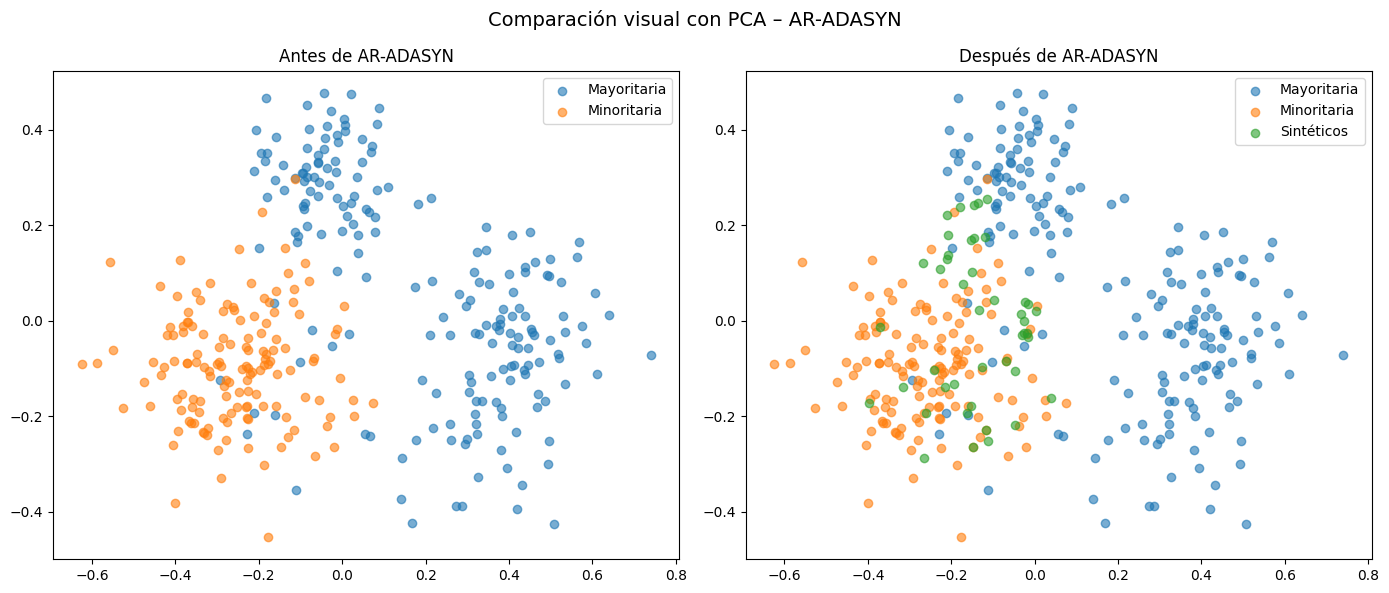

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción a 2D con PCA (original sin sintéticos)
pca = PCA(n_components=2)
X_vis_orig = pca.fit_transform(np.vstack([X_min, X_maj]))
y_vis_orig = np.hstack([np.ones(len(X_min)), np.zeros(len(X_maj))])

# Reducción a 2D con PCA (incluyendo sintéticos)
X_vis_aradasyn = pca.transform(np.vstack([X_min, X_maj, X_sinteticas]))
y_vis_aradasyn = np.hstack([
    np.ones(len(X_min)),
    np.zeros(len(X_maj)),
    np.full(len(X_sinteticas), 2)
])

# Gráfico comparativo
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original
axs[0].scatter(X_vis_orig[y_vis_orig == 0][:, 0], X_vis_orig[y_vis_orig == 0][:, 1], alpha=0.6, label='Mayoritaria', color='tab:blue')
axs[0].scatter(X_vis_orig[y_vis_orig == 1][:, 0], X_vis_orig[y_vis_orig == 1][:, 1], alpha=0.6, label='Minoritaria', color='tab:orange')
axs[0].set_title("Antes de AR-ADASYN")
axs[0].legend()

# Con AR-ADASYN
axs[1].scatter(X_vis_aradasyn[y_vis_aradasyn == 0][:, 0], X_vis_aradasyn[y_vis_aradasyn == 0][:, 1], alpha=0.6, label='Mayoritaria', color='tab:blue')
axs[1].scatter(X_vis_aradasyn[y_vis_aradasyn == 1][:, 0], X_vis_aradasyn[y_vis_aradasyn == 1][:, 1], alpha=0.6, label='Minoritaria', color='tab:orange')
axs[1].scatter(X_vis_aradasyn[y_vis_aradasyn == 2][:, 0], X_vis_aradasyn[y_vis_aradasyn == 2][:, 1], alpha=0.6, label='Sintéticos', color='tab:green')
axs[1].set_title("Después de AR-ADASYN")
axs[1].legend()

plt.suptitle("Comparación visual con PCA – AR-ADASYN", fontsize=14)
plt.tight_layout()
plt.show()
